In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta

from sklearn.base import clone
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.inspection import DecisionBoundaryDisplay

import os
import sys
sys.path.append(os.path.join(os.path.abspath(''), '..'))
from utils.transformer import WaveletTransformer
from utils.kernels import generalized_cone_kernel

sns.set_theme('notebook', 'whitegrid', 'dark')

In [46]:
X_train = np.load('../data/X_train.npy')
y_train = np.load('../data/y_train.npy')
groups_train = np.load('../data/groups_train.npy')
severities_train = np.load('../data/severities_train.npy')

In [47]:
def create_kernel(gamma, beta):
    def kernel(X, Y):
        return generalized_cone_kernel(X, Y, gamma, beta)
    return kernel

pipeline = Pipeline([
    ('wavelet_transformer', WaveletTransformer(w_list=[125, 3448], n_samples=100, n_frequencies=20)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=90)),
    ('svm', SVC(probability=True, kernel=create_kernel(0.8947, 895.7), C=31.5))
])

pipeline.fit(X_train, y_train);

In [48]:
X_test = np.load('../data/X_test.npy')
y_test = np.load('../data/y_test.npy')
groups_test = np.load('../data/groups_test.npy')
severities_test = np.load('../data/severities_test.npy')

In [49]:
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)

Accuracy: 91.86%
AUC ROC: 0.98


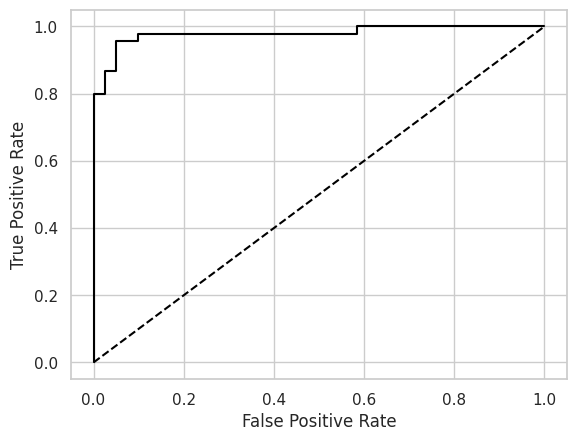

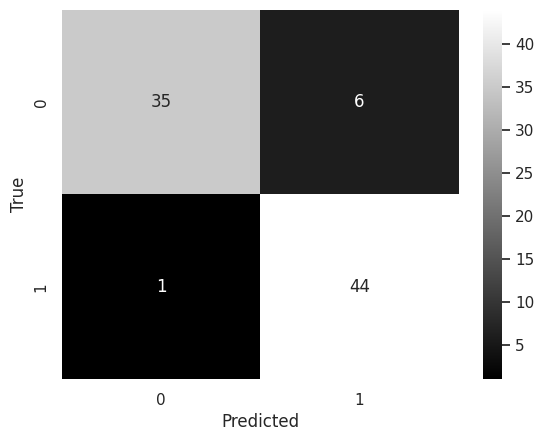

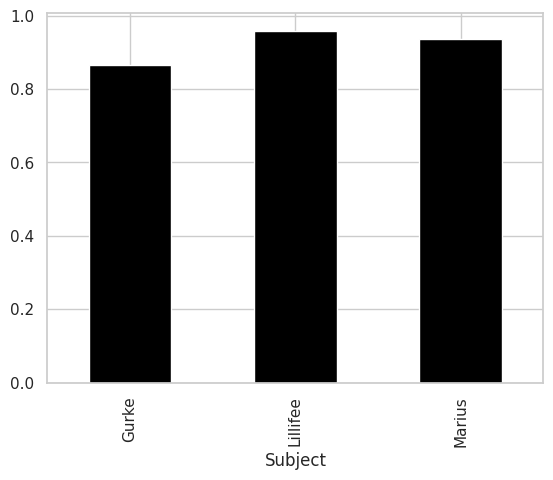

In [50]:
accuracy = np.mean(y_pred == y_test)
print(f'Accuracy: {accuracy:.2%}')

auc_roc = roc_auc_score(y_test, y_pred_proba[:, 1])
print(f'AUC ROC: {auc_roc:.2f}')

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
plt.plot(fpr, tpr, color='black')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap='grey')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

df = pd.DataFrame({'y': y_test, 'y_pred': y_pred, 'Subject': groups_test})
df['correct'] = df['y'] == df['y_pred']
df.groupby('Subject').mean()['correct'].plot(kind='bar', color='black');

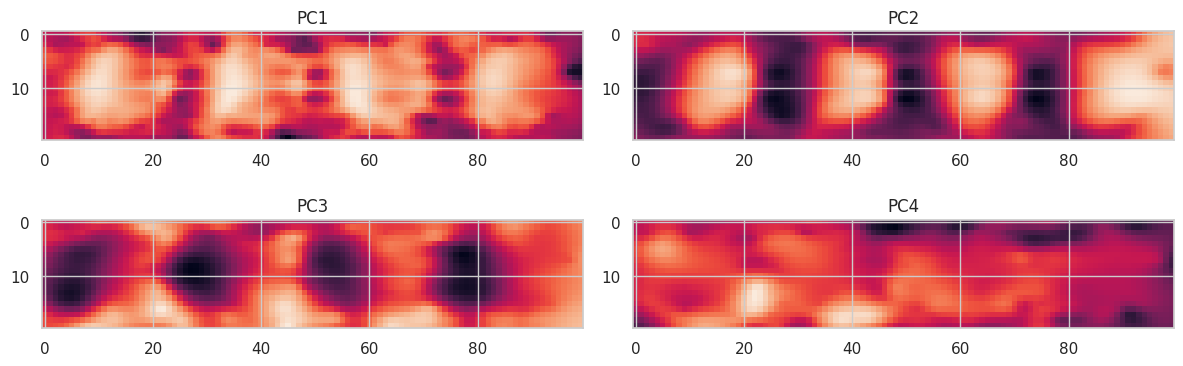

In [51]:
pca = pipeline.named_steps['pca']

num_plots = min(len(pca.components_), 4)
num_cols = 2
num_rows = (num_plots + 1)//num_cols
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(6*num_cols, 2*num_rows))

for row in range(num_rows):
    for col in range(num_cols):
        idx = row*num_cols + col
        if idx >= num_plots:
            break
        pc = pca.components_[idx]
        pc = np.moveaxis(pc.reshape(-1, 20, 100), 0, -1)
        axes[row, col].imshow(pc[:,:,0])
        axes[row, col].set_title('PC' + str(idx + 1))
fig.tight_layout()
plt.show()

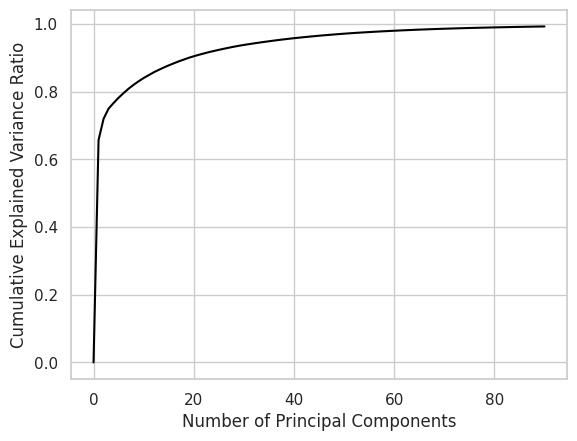

In [52]:
cumulative_explained_variance_ratio = np.concatenate((np.zeros(1), pca.explained_variance_ratio_)).cumsum()
num_components = len(cumulative_explained_variance_ratio)
plt.plot(range(0, num_components), cumulative_explained_variance_ratio, color='black')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()

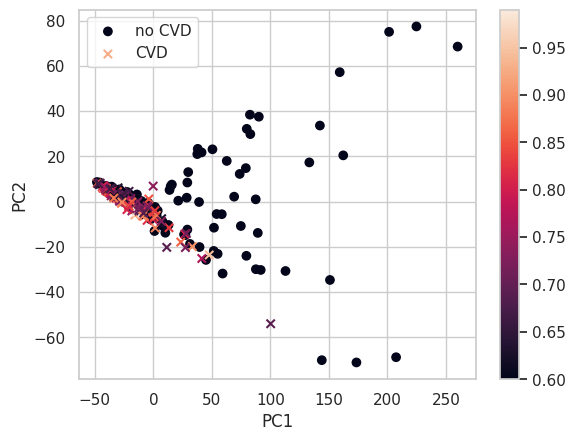

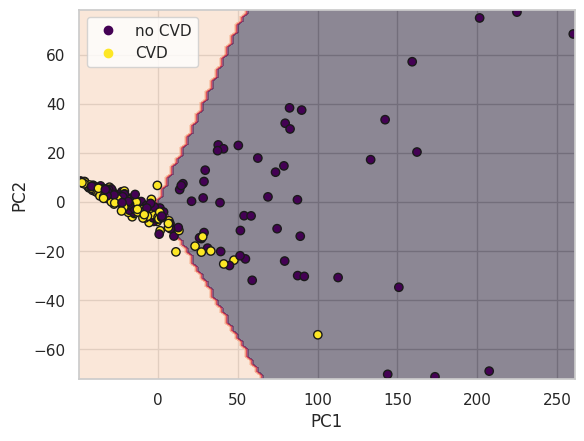

In [53]:
X_pca = pipeline.named_steps['wavelet_transformer'].transform(X_train)
X_pca = pipeline.named_steps['scaler'].transform(X_pca)
X_pca = pipeline.named_steps['pca'].transform(X_pca)

markers = ['o', 'x']
for i, marker in enumerate(markers):
    plt.scatter(X_pca[y_train == i, 0], X_pca[y_train == i, 1], marker=marker, label='CVD' if i == 1 else 'no CVD', c=np.array(severities_train)[y_train == i])

plt.legend()
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

X_reduced = X_pca[:,:2]

model = clone(pipeline.named_steps['svm'])

model.fit(X_reduced, y_train)
disp = DecisionBoundaryDisplay.from_estimator(
    model, X_reduced, response_method="predict",
    xlabel='PC1', ylabel='PC2',
    alpha=0.5,
)
scatter = disp.ax_.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_train, edgecolors='k', cmap='viridis')
disp.ax_.legend(handles=scatter.legend_elements()[0], labels=['no CVD', 'CVD'])
plt.show()

In [73]:
X_cvd = np.load('../data/X_cvd.npy')
y_cvd = np.load('../data/y_cvd.npy')
groups_cvd = np.load('../data/groups_cvd.npy')
severities_cvd = np.load('../data/severities_cvd.npy')

In [74]:
y_pred_cvd = pipeline.predict(X_cvd)
y_pred_proba_cvd = pipeline.predict_proba(X_cvd)

Accuracy: 44.29%
AUC ROC: 0.50


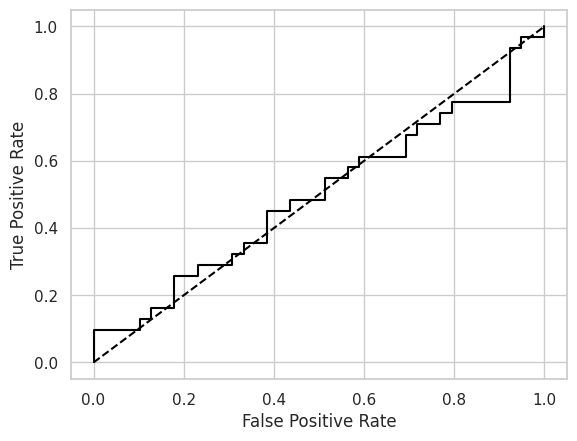

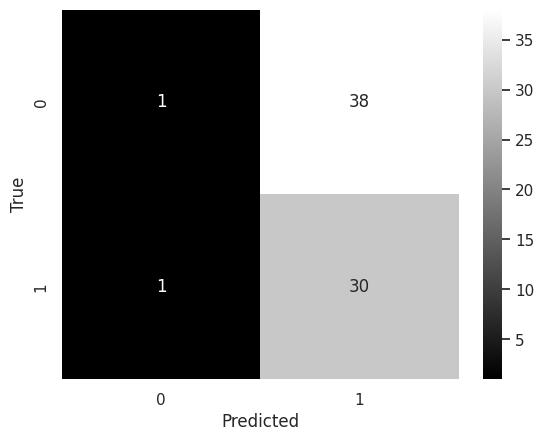

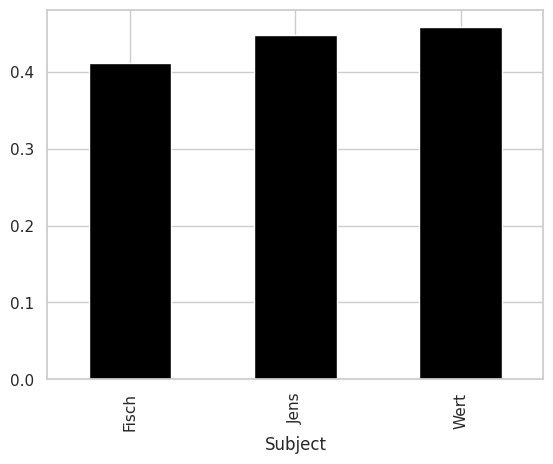

In [75]:
accuracy = np.mean(y_pred_cvd == y_cvd)
print(f'Accuracy: {accuracy:.2%}')

auc_roc = roc_auc_score(y_cvd, y_pred_proba_cvd[:, 1])
print(f'AUC ROC: {auc_roc:.2f}')

fpr, tpr, thresholds = roc_curve(y_cvd, y_pred_proba_cvd[:, 1])
plt.plot(fpr, tpr, color='black')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

conf_matrix = confusion_matrix(y_cvd, y_pred_cvd)
sns.heatmap(conf_matrix, annot=True, cmap='grey')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

df = pd.DataFrame({'y': y_cvd, 'y_pred': y_pred_cvd, 'Subject': groups_cvd})
df['correct'] = df['y'] == df['y_pred']
df.groupby('Subject').mean()['correct'].plot(kind='bar', color='black');

Not Simulated
a: 0.65, b: 1.39


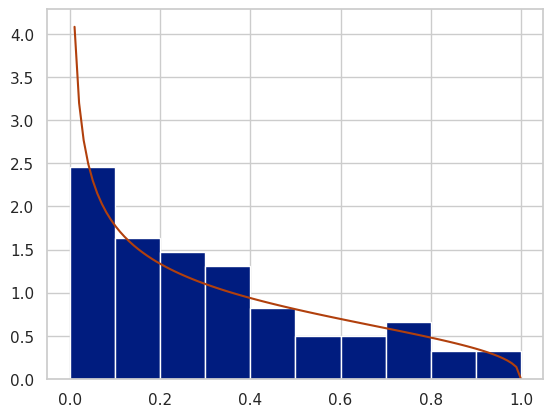

Simulated
a: 1.13, b: 0.37


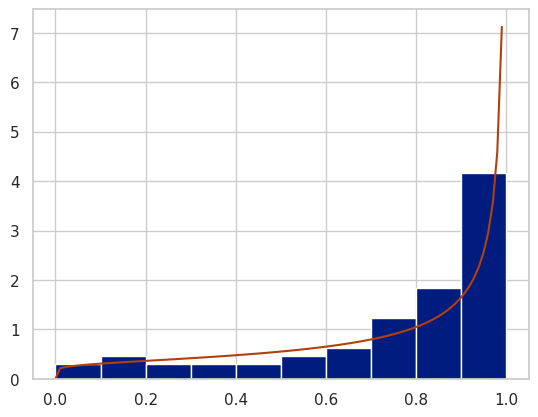

CVD


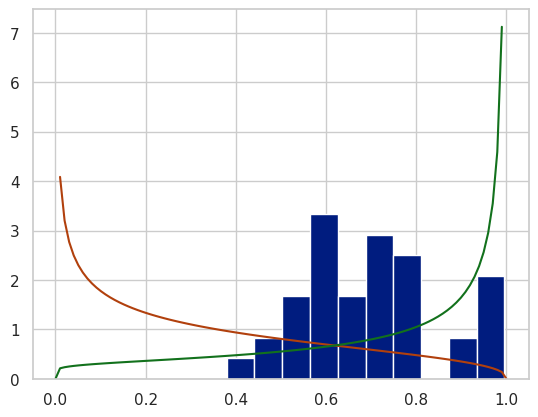

In [78]:
simulated = y_pred_proba[y_test == 1][:, 1]
not_simulated = y_pred_proba[y_test == 0][:, 1]

simulated = np.concatenate((simulated, np.linspace(0, 1, 20)))
not_simulated = np.concatenate((not_simulated, np.linspace(0, 1, 20)))

mu_not_simulated = np.mean(not_simulated)
sigma_not_simulated = np.std(not_simulated)
a_not_simulated = mu_not_simulated*(mu_not_simulated*(1-mu_not_simulated)/sigma_not_simulated**2 - 1)
b_not_simulated = (1-mu_not_simulated)*(mu_not_simulated*(1-mu_not_simulated)/sigma_not_simulated**2 - 1)

mu_simulated = np.mean(simulated)
sigma_simulated = np.std(simulated)
a_simulated = mu_simulated*(mu_simulated*(1-mu_simulated)/sigma_simulated**2 - 1)
b_simulated = (1-mu_simulated)*(mu_simulated*(1-mu_simulated)/sigma_simulated**2 - 1)

# regularization_strength = 0.25
# a_not_simulated += regularization_strength * (1 - a_not_simulated)
# b_not_simulated += regularization_strength * (1 - b_not_simulated)
# a_simulated += regularization_strength * (1 - a_simulated)
# b_simulated += regularization_strength * (1 - b_simulated)

print('Not Simulated')
print(f'a: {a_not_simulated:.2f}, b: {b_not_simulated:.2f}')
plt.hist(not_simulated, density=True)
plt.plot(np.linspace(0, 1, 100), beta.pdf(np.linspace(0, 1, 100), a_not_simulated, b_not_simulated))
plt.show()

print('Simulated')
print(f'a: {a_simulated:.2f}, b: {b_simulated:.2f}')
plt.hist(simulated, density=True)
plt.plot(np.linspace(0, 1, 100), beta.pdf(np.linspace(0, 1, 100), a_simulated, b_simulated))
plt.show()

print('CVD')
plt.hist(y_pred_proba_cvd[y_cvd == 0][:, 1], density=True)
plt.plot(np.linspace(0, 1, 100), beta.pdf(np.linspace(0, 1, 100), a_not_simulated, b_not_simulated))
plt.plot(np.linspace(0, 1, 100), beta.pdf(np.linspace(0, 1, 100), a_simulated, b_simulated))
plt.show()

Subject: Marius, Accuracy: 93.33%
Log Likelihood No CVD: 7.7779830956507165
Log Likelihood CVD: -16.115918060243246
No CVD


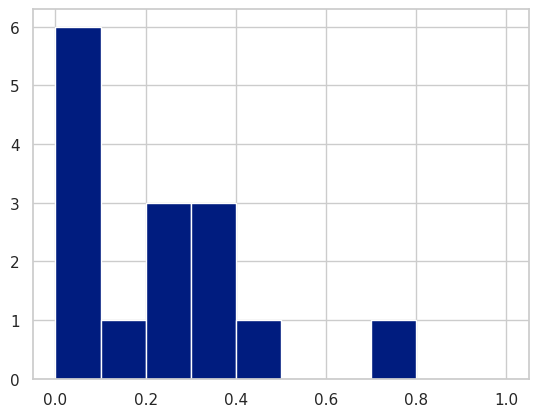

Subject: Gurke, Accuracy: 73.33%
Log Likelihood No CVD: 3.7026696957628826
Log Likelihood CVD: -13.987498984795337
No CVD


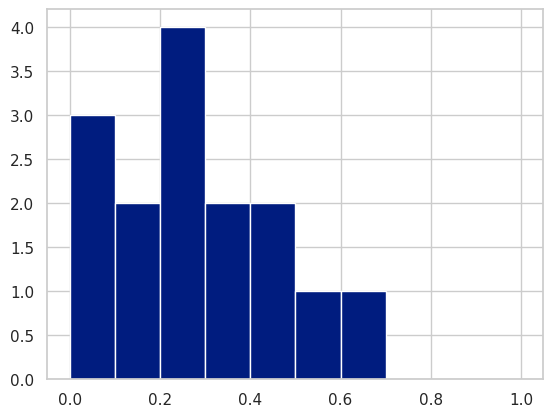

Subject: Lillifee, Accuracy: 90.91%
Log Likelihood No CVD: 5.004819958550776
Log Likelihood CVD: -11.63948652418972
No CVD


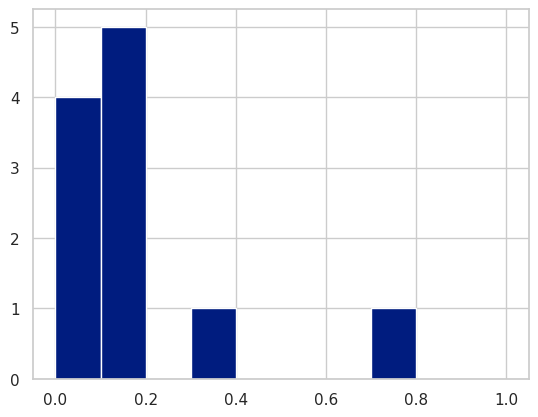

Subject: Jens, Accuracy: 6.25%
Log Likelihood No CVD: -6.128675642193354
Log Likelihood CVD: -6.366131228549383
No CVD


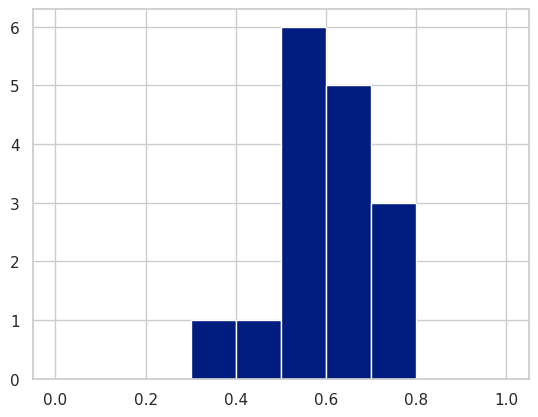

Subject: Fisch, Accuracy: 0.00%
Log Likelihood No CVD: -13.495781267679737
Log Likelihood CVD: 9.984832940588486
CVD


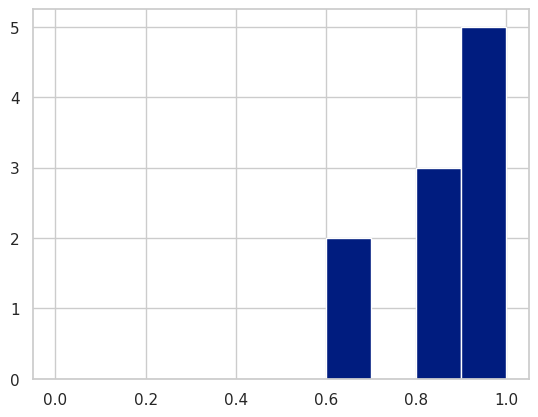

Subject: Wert, Accuracy: 0.00%
Log Likelihood No CVD: -6.421208236088575
Log Likelihood CVD: -3.4351176099760923
CVD


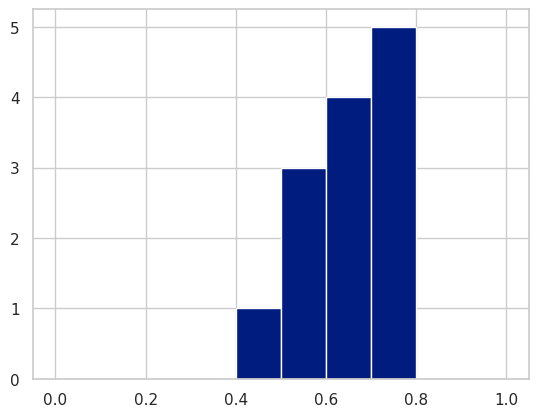

In [79]:
for group in set(groups_test):
    y_group_pred = y_pred[np.logical_and(groups_test == group, y_test == 0)]
    y_group_pred_proba = y_pred_proba[np.logical_and(groups_test == group, y_test == 0)]
    print(f'Subject: {group}, Accuracy: {np.mean(y_group_pred == 0):.2%}')
    log_likelihood_no_cvd = np.sum(beta.logpdf(y_group_pred_proba[:, 1], a_not_simulated, b_not_simulated))
    log_likelihood_cvd = np.sum(beta.logpdf(y_group_pred_proba[:, 1], a_simulated, b_simulated))
    print(f'Log Likelihood No CVD: {log_likelihood_no_cvd}')
    print(f'Log Likelihood CVD: {log_likelihood_cvd}')
    if log_likelihood_no_cvd > log_likelihood_cvd:
        print('No CVD')
    else:
        print('CVD')
        
    plt.hist(y_group_pred_proba[:, 1], range=(0, 1))
    plt.show()

for group in set(groups_cvd):
    y_group_pred = y_pred_cvd[np.logical_and(groups_cvd == group, y_cvd == 0)]
    y_group_pred_proba = y_pred_proba_cvd[np.logical_and(groups_cvd == group, y_cvd == 0)]
    print(f'Subject: {group}, Accuracy: {np.mean(y_group_pred == 0):.2%}')
    log_likelihood_no_cvd = np.sum(beta.logpdf(y_group_pred_proba[:, 1], a_not_simulated, b_not_simulated))
    log_likelihood_cvd = np.sum(beta.logpdf(y_group_pred_proba[:, 1], a_simulated, b_simulated))
    print(f'Log Likelihood No CVD: {log_likelihood_no_cvd}')
    print(f'Log Likelihood CVD: {log_likelihood_cvd}')
    if log_likelihood_no_cvd > log_likelihood_cvd:
        print('No CVD')
    else:
        print('CVD')
        
    plt.hist(y_group_pred_proba[:, 1], range=(0, 1))
    plt.show()